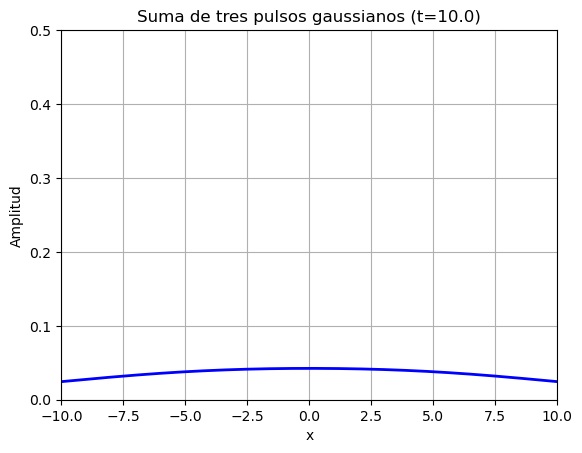

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Definimos tu función ---
def multi_pulse(x, t):
    p1, p2, p3 = 0.5, 1.0, 0.5
    s = 2 + t #np.cos(t)
    g1 = np.exp(-(x+5)**2 / (2*(p1 * s)**2)) / np.sqrt(2 * np.pi * (p1 * s)**2)
    g2 = np.exp(-(x)**2   / (2*(p2 * s)**2)) / np.sqrt(2 * np.pi * (p2 * s)**2)
    g3 = np.exp(-(x-5)**2 / (2*(p3 * s)**2)) / np.sqrt(2 * np.pi * (p3 * s)**2)
    return (g1 + g2 + g3)/3

# --- Dominio espacial ---
x = np.linspace(-10, 10, 1000)

# --- Configuración de la figura ---
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color="blue")
ax.set_xlim(-10, 10)
ax.set_ylim(0, 0.5)
ax.set_title("Suma de tres pulsos gaussianos")
ax.set_xlabel("x")
ax.set_ylabel("Amplitud")
ax.grid(True)

# --- Función de inicialización ---
def init():
    line.set_data([], [])
    return line,

# --- Función de actualización para cada frame ---
def update(frame):
    t = 0.1 + frame * 0.1   # evita dividir entre cero
    y = multi_pulse(x, t)
    line.set_data(x, y)
    ax.set_title(f"Suma de tres pulsos gaussianos (t={t:.1f})")
    return line,

# --- Crear la animación ---
ani = FuncAnimation(fig, update, frames=100, init_func=init,
                    blit=True, interval=100)

ani.save("multi_pulse_animation.gif", writer='pillow', fps=10)


Reconstrucción relativa (Frobenius) con r=10: 3.607e-04


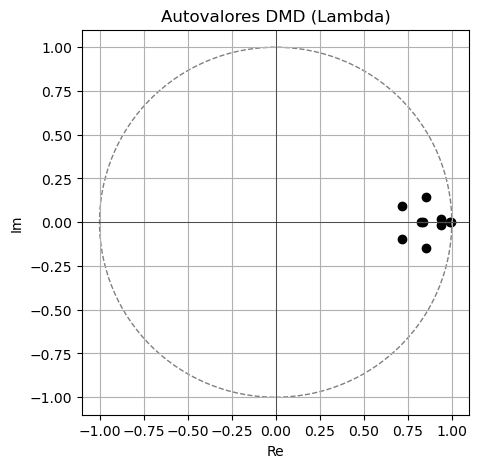

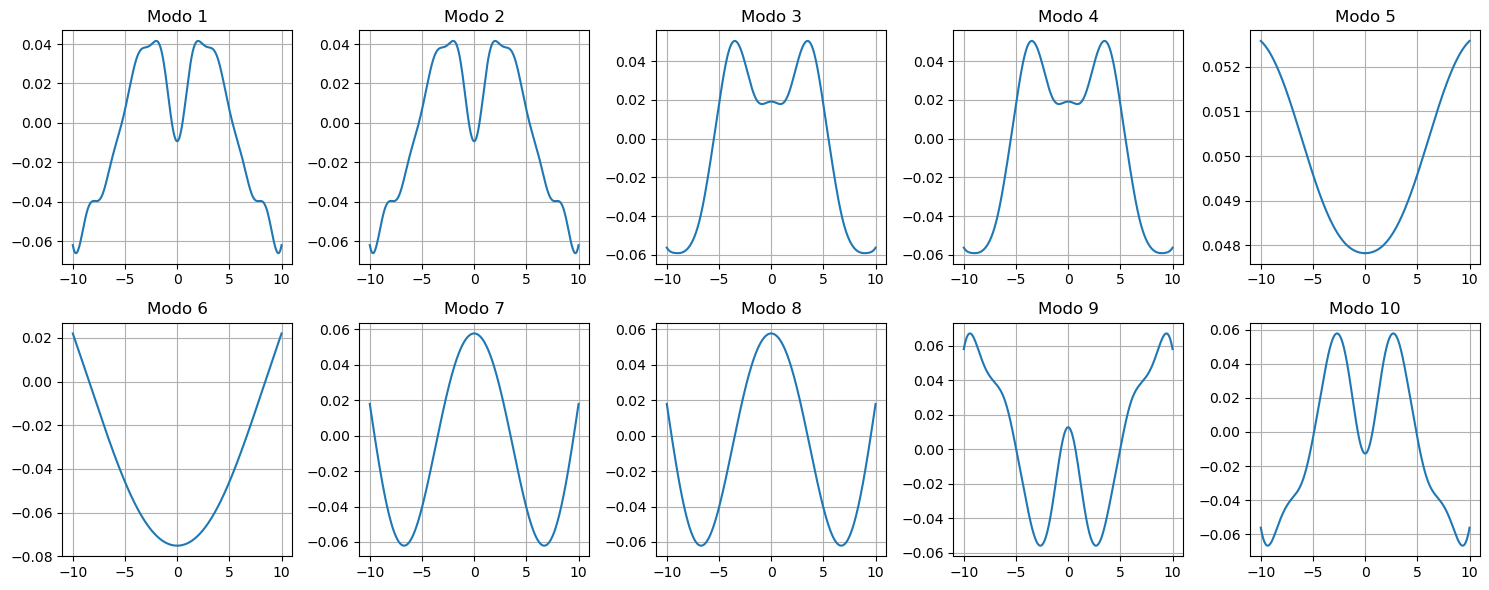

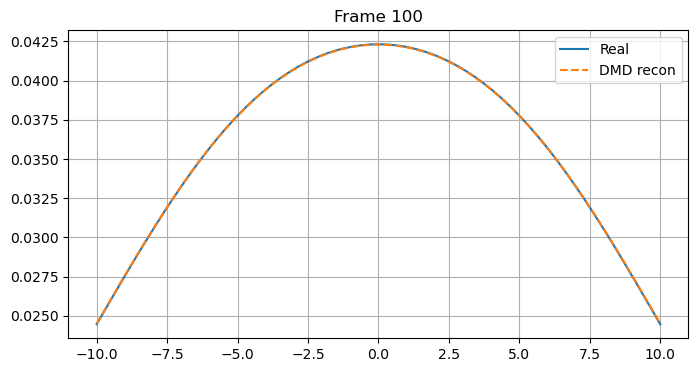

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, eig
from matplotlib.animation import FuncAnimation

# --- Tu función de pulsos (tal como la tienes) ---
def multi_pulse(x, t):
    p1, p2, p3 = 0.5, 1.0, 0.5
    s = 2 + t
    g1 = np.exp(-(x+5)**2 / (2*(p1 * s)**2)) / np.sqrt(2 * np.pi * (p1 * s)**2)
    g2 = np.exp(-(x)**2   / (2*(p2 * s)**2)) / np.sqrt(2 * np.pi * (p2 * s)**2)
    g3 = np.exp(-(x-5)**2 / (2*(p3 * s)**2)) / np.sqrt(2 * np.pi * (p3 * s)**2)
    return (g1 + g2 + g3)/3

# --- Generar snapshots en espacio x y tiempos t_k ---
x = np.linspace(-10, 10, 400)
t_series = np.linspace(0.1, 20, 201)  # evita t=0 por división
dt = t_series[1] - t_series[0]

# snapshot matrix: cada columna = estado en un tiempo
X = np.column_stack([multi_pulse(x, t) for t in t_series])

# --- (Opcional) eliminar la media temporal ---
# X_mean = X.mean(axis=1, keepdims=True)
# Xc = X - X_mean
Xc = X.copy()

# --- Construir X1, X2 (desplazadas) ---
X1 = Xc[:, :-1]   # columnas 0..m-2
X2 = Xc[:, 1:]    # columnas 1..m-1

# --- DMD (exact DMD/Tu et al.) ---
def compute_dmd(X1, X2, r=None):
    # SVD
    U, S, Vh = svd(X1, full_matrices=False)
    if r is None:
        # elegir r por energía (por ejemplo, 99%)
        energy = np.cumsum(S**2)/np.sum(S**2)
        r = np.searchsorted(energy, 0.99) + 1
    U_r = U[:, :r]
    S_r = np.diag(S[:r])
    V_r = Vh.conj().T[:, :r]
    
    # Matriz A_tilde
    A_tilde = U_r.T @ X2 @ V_r @ np.linalg.inv(S_r)
    # Eigen-decomp
    Lambda, W = eig(A_tilde)
    # DMD modes (exact)
    Phi = X2 @ V_r @ np.linalg.inv(S_r) @ W
    return Phi, Lambda, U_r, S_r, V_r

# calcula DMD
r = 10  # puedes ajustar
Phi, Lambda, U_r, S_r, V_r = compute_dmd(X1, X2, r=r)

# --- calcular amplitudes (condiciones iniciales) ---
# representamos el primer snapshot X1[:,0] en la base de modos
x0 = X1[:, 0]
# resolver Phi * b = x0 por mínimos cuadrados
b, *_ = np.linalg.lstsq(Phi, x0, rcond=None)

# convertir autovalores a crecimiento/rotación continuo (omega)
omega = np.log(Lambda) / dt

# --- reconstrucción y predicción ---
def reconstruct(Phi, Lambda, b, time_points):
    """
    Reconstruye en una lista de tiempos (pueden ser continuos),
    usando x(t) = sum_j b_j phi_j exp(omega_j t).
    time_points: array de tiempos relativos (t - t0)
    """
    modes_t = np.array([b[j] * Phi[:, j][:, None] * np.exp(omega[j] * time_points[None, :])
                        for j in range(Phi.shape[1])])
    X_rec = modes_t.sum(axis=0)  # forma (n_space, n_times)
    return X_rec.real

# reconstruir en los tiempos originales (relativos a t0)
t_rel = (t_series[:-1] - t_series[0])  # porque X1 empezó en t_series[0]
X_rec = reconstruct(Phi, Lambda, b, t_rel)

# --- Evaluar error ---
err = np.linalg.norm(X1 - X_rec, 'fro') / np.linalg.norm(X1, 'fro')
print(f"Reconstrucción relativa (Frobenius) con r={r}: {err:.3e}")

# --- Plots: autovalores, modos y comparación en un tiempo ---
# 1) Autovalores en plano complejo
plt.figure(figsize=(5,5))
plt.scatter(Lambda.real, Lambda.imag, c='k')
unit = plt.Circle((0,0), 1.0, color='gray', fill=False, ls='--')
plt.gca().add_patch(unit)
plt.axhline(0, color='k', lw=0.4); plt.axvline(0, color='k', lw=0.4)
plt.title('Autovalores DMD (Lambda)')
plt.xlabel('Re'); plt.ylabel('Im')
plt.grid(True)
plt.show()

# 2) Tres primeros modos (reales) espaciales
nplot = min(10, Phi.shape[1])
plt.figure(figsize=(15,6))
for i in range(nplot):
    plt.subplot(2, (nplot+1)//2, i+1)
    plt.plot(x, Phi[:, i].real)
    plt.title(f'Modo {i+1}')
    plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Comparación snapshot real vs reconstrucción en un frame
frame_idx = 100
plt.figure(figsize=(8,4))
plt.plot(x, X1[:, frame_idx], label='Real')
plt.plot(x, X_rec[:, frame_idx].real, '--', label='DMD recon')
plt.legend(); plt.title(f'Frame {frame_idx}')
plt.grid(True)
plt.show()


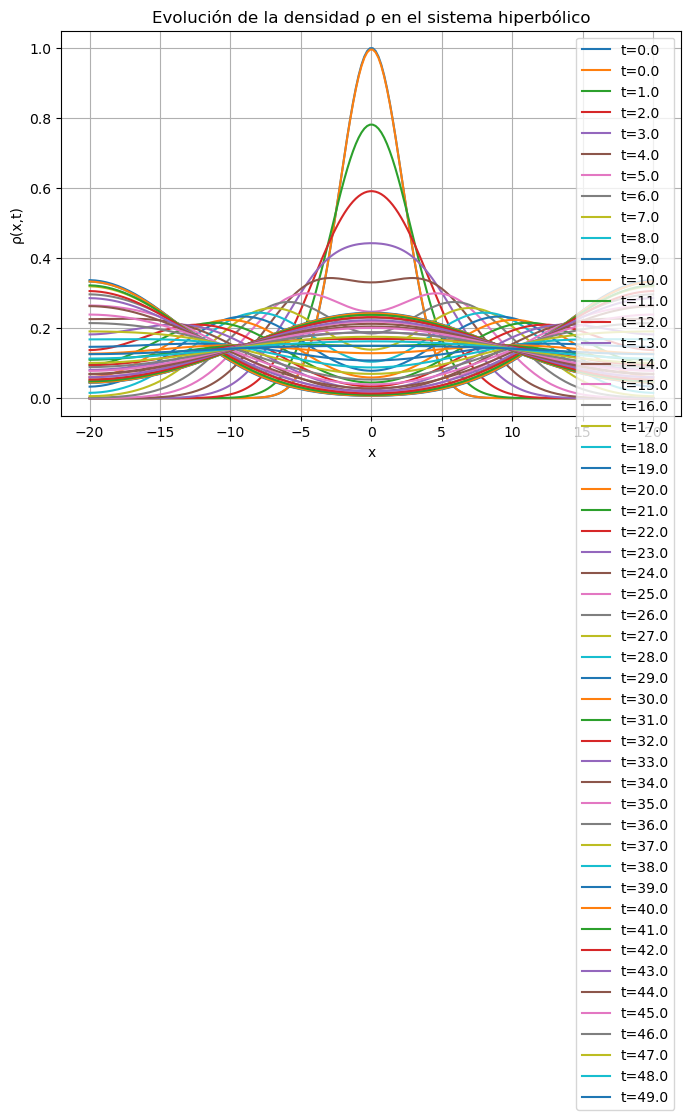

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros numéricos ---
Nx = 200         # puntos espaciales
Lx = 20.0        # dominio [-Lx, Lx]
dx = 2*Lx/Nx
x = np.linspace(-Lx, Lx, Nx)

dt = 0.02        # paso de tiempo
T  = 50.0        # tiempo total
Nt = int(T/dt)

# --- Condiciones iniciales ---
rho = np.exp(-x**2/10)      # densidad inicial: campana
u   = np.zeros_like(x)   # velocidad inicial: reposo

# --- Guardar resultados ---
RHO = [rho.copy()]
U   = [u.copy()]
times = [0.0]

# --- Evolución temporal (Lax-Friedrichs) ---
for n in range(Nt):
    rho_next = 0.5*(np.roll(rho,-1) + np.roll(rho,1)) - (dt/(2*dx))*(np.roll(u,-1) - np.roll(u,1))
    u_next   = 0.5*(np.roll(u,-1)   + np.roll(u,1))   - (dt/(2*dx))*(np.roll(rho,-1) - np.roll(rho,1))
    rho, u = rho_next, u_next
    
    if n % 50 == 0:
        RHO.append(rho.copy())
        U.append(u.copy())
        times.append((n+1)*dt)

# --- Graficar perfiles de rho en distintos tiempos ---
plt.figure(figsize=(8,5))
for k in range(len(RHO)):
    plt.plot(x, RHO[k], label=f"t={times[k]:.1f}")
plt.xlabel("x")
plt.ylabel("ρ(x,t)")
plt.title("Evolución de la densidad ρ en el sistema hiperbólico")
plt.legend()
plt.grid(True)
plt.show()


# Bayesian system identification

## Algorithms
DMD, SINDy, Linear and Unscented Kalman filters

## Linear pendulum

## Non linear pendulum

## Van der Pol

## Lorenz

## Reaction-diffusion